# Transform between logos of different types

Logomaker supports multiple different logo types and allows the user to seamlessly transform
from one type of logo to another by using the method [transform_matrix](https://logomaker.readthedocs.io/en/latest/matrix.html#transform-matrix). A matrix is defined by a set of textual
characters, a set of numerical positions, and a numerical quantity for every character-position pair. In what
follows, we use the symbol $i$ to represent possible positions, and the symbol $c$ (or $c'$)
to represent possible characters.

Any matrix can be represented as a logo in a straight-forward manner. Given a matrix,
a corresponding logo is drawn by stacking  the unique characters on top of one another
at each specified position. Each character at each position is drawn with a height given
by the value of the corresponding matrix element.

Characters with positive heights are stacked on top of one another starting from a baseline value of 0,
whereas characters with heights less than zero are stacked below one another starting from the baseline.
Logomaker provides the option of flipping characters with negative height upside down and/or darkening
the color with which such characters are drawn. Although Logomaker will draw logos corresponding to any user-specified matrix, additional support
is provided for matrices of five specific types: counts matrix, probability matrix, weight matrix,
saliency matrix, and information matrix. Apart from saliency, each matrix type directly or indirectly
represents the marginal statistics of a sequence alignment, and Logomaker can generate any
one of these types of matrices from a sequence alignment supplied by the user. These matrices and their allowed transformations are described in detail in this tutorial.

The transformations that can be performed are listed below:

1. **Center values**:
    Subtracts the mean from each row in df. This is common for weight
    matrices or energy matrices. To do this, set center_values=True.
<br><br>
2. **Normalize values**:
    Divides each row by the sum of the row. This is needed for probability
    matrices. To do this, set normalize_values=True.
<br><br>
3. **From** $\rightarrow$ **To transformations**:
    Transforms from one type of matrix (e.g. 'counts') to another type
    of matrix (e.g. 'information'). To do this, set from_type and to_type
    arguments.
    
<img src="table_for_tutorial_3.png" height="600" width="600" />

Using these five 1-step transformations, 2-step transformations
are also enabled, e.g., from_type=‘counts' $\rightarrow$ to_type=‘information'. We show the transform matrix functionality by transforming the CRP logo.

We begin by importing useful packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.ion()

import sys
sys.path.append('../../')

import logomaker as lm

## CRP logo transformations

A counts matrix represent the number of occurrences of each character at each position within a sequence
alignment (although the user can choose to exclude certain characters, e.g., '-' character representing gaps).
Specifically, a counts matrix has entries $n_{ic}$ that represent the number of occurrences of character
$c$ at position $i$. These $n_{ic}$ values are all required to be greater or equal to zero. Counts logos are
assigned character heights corresponding to these $n_{ic}$ values. The y axis of such logos extends from 0 to
$N$, where $N$ is the number of sequences in the alignment. Note that, Because certain
characters might be excluded when computing $n_{ic}$ from an alignment, it is possible to have
$\sum_c n_{ic} < N$ at some positions.

We get the crp counts matrix by running the Logomaker method [get_example_matrix](https://logomaker.readthedocs.io/en/latest/examples_src.html#get-example-matrix) with the argument 'crp_counts_matrix':

In [2]:
counts_mat = lm.get_example_matrix('crp_counts_matrix')
counts_mat.head()

Description of example matrix "crp_counts_matrix":
# 
# CRP counts matrix. Created from the CRP binding sites from listed in RegulonDB.
# 
# References
# 
# Salgado H, et al. (2013) RegulonDB v8.0: omics data sets, evolutionary
# conservation, regulatory phrases, cross-validated gold standards
# and more. Nucl Acids Res. 41(Database issue):D203–13.
# 
# 



,A,C,G,T
pos,,,,
0,133.0,65.0,72.0,88.0
1,147.0,46.0,58.0,107.0
2,166.0,26.0,38.0,128.0
3,164.0,28.0,43.0,123.0
4,133.0,45.0,47.0,133.0


We can draw this logo using the [Logo](https://logomaker.readthedocs.io/en/latest/Logo.html) class

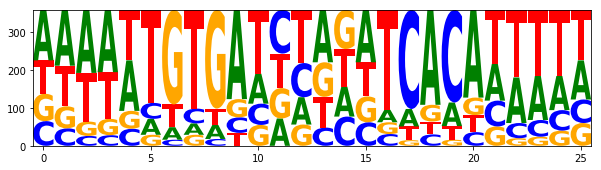

In [3]:
lm.Logo(counts_mat)

The following cells of this notebook show how to apply different Logo transformations to the CRP matrix.

### Counts matrix to probability matrix

A probability matrix represents the probability of observing each possible character at each possible position
within a certain type of sequence. Probability matrix elements are denoted by $p_{ic}$ and can be estimated
from a counts matrix via

$p_{ic} = \frac{n_{ic} + \lambda}{\sum_{c'} n_{ic'} + C \lambda}$

where $C$ is the number of possible characters and $\lambda$ is a user-defined pseudocount.
A probability logo has heights given by these $p_{ic}$ values. The y axis extends from 0 to 1. The transformation from counts matrix to a probability matrix is shown below:

In [4]:
# Counts matrix -> Probability matrix
prob_mat = lm.transform_matrix(counts_mat, from_type='counts', to_type='probability')

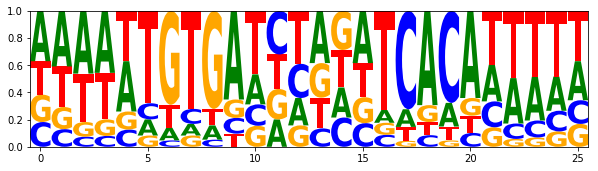

In [5]:
lm.Logo(prob_mat)

### Counts matrix to information matrix

Information logos were described in the original 1990 paper of Schneider and Stephens ([1](#weblogo1990)),
and remain the most popular type of sequence logo. The entries $I_{ic}$ in the corresponding information matrices
are given by

$I_{ic} = p_{ic} I_i,~~~I_i = \sum_c p_{ic} \log_2 \frac{p_{ic}}{b_{ic}}$

The position-dependent (but not character dependent) quantity $I_i$ is called the "information content"
of site $i$, and the sum of these quantities, $I = \sum_{i} I_i$, is the information content
of the entire matrix. These information values $I_{ic}$  are nonnegative and are said to be in units of
'bits' due to the use of $\log_2$. 

A information matrix from counts matrix transformation is shown below.

In [6]:
# Counts matrix -> Information matrix
info_mat = lm.transform_matrix(counts_mat, 
                                      from_type='counts', 
                                      to_type='information')

A corresponding information logo is drawn using these $I_{ic}$ values as character heights.

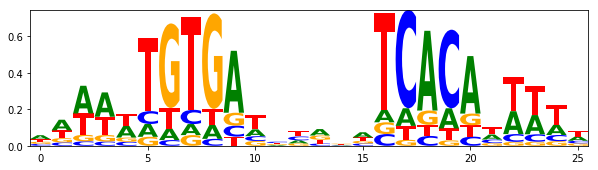

In [7]:
lm.Logo(info_mat)

### Information matrix to proability matrix

We show how to transform from an information matrix back to probability.

In [8]:
# Information matrix -> Probability matrix
prob_mat_2 = lm.transform_matrix(info_mat, 
                                from_type='information', 
                                to_type='probability')

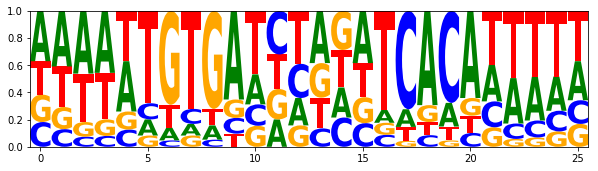

In [9]:
lm.Logo(prob_mat_2)

### Counts matrix to weight matrix

A weight matrix draws characters with positive values above the x-axis and draw characters with negative
values below it. A weight matrix can be used to represent an enrichment logo, where the relative likelihood
of observing each character at each position is relative to some user-specified "background" model.
Such matrices are sometimes referred to as position weight matrices (PWMs) or position-specific
scoring matrices (PSSMs). The elements $w_{ic}$ of an enrichment matrix can be computed from a
probability matrix (elements $p_{ic}$) and a background matrix
(also a probability matrix but denoted $b_{ic}$) using the formula

$w_{ic} = \log_2 \frac{p_{ic}}{b_{ic}}$

This equation can be inverted to give $p_{ic}$:

$p_{ic} = \frac{b_{ic} 2^{w_{ic}}}{ \sum_{c'} b_{ic'} 2^{w_{ic'}} }$

where the denominator is included to explicitly enforce the the requirement that $\sum_c p_{ic} = 1$ at
every $i$. Note that $b_{ic}$ will often not depend on $i$, but it does vary with $i$ in some cases, such as
computation of enrichment scores in deep mutational scanning experiments. Enrichment logos have heights given
by the $w_{ic}$ values, which can be either positive or negative.

The following snippet shows a transformation from counts to weights matrix with a user-specified background.

In [10]:
# create a user specified background
gc = .51
background = [(1-gc)/2, gc/2, gc/2, (1-gc)/2]

In [11]:
# Counts matrix -> weight matrix
weight_mat = lm.transform_matrix(counts_mat,
                                 background=background,            
                                 from_type='counts', 
                                 to_type='weight')

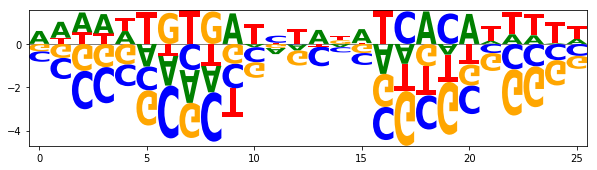

In [12]:
lm.Logo(weight_mat)

We show how to transform from a weight matrix back to probability.

In [13]:
prob_mat3 = lm.transform_matrix(weight_mat,           
                                 from_type='weight', 
                                 to_type='probability')

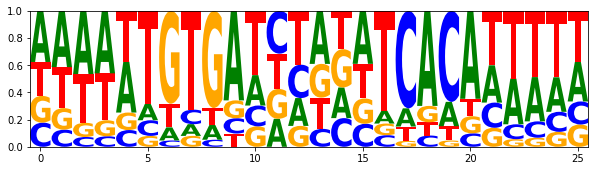

In [14]:
lm.Logo(prob_mat3)

### Center values transformation

The center values transformation subtracts the mean from each row in the input matrix. This is common for weight
matrices or energy matrices. To do this, set center_values=True in transform_matrix().

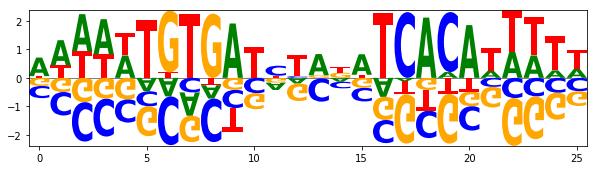

In [15]:
weight_mat_centered = lm.transform_matrix(weight_mat, center_values=True)
lm.Logo(weight_mat_centered)

### Normalize transformation

The normalize transformation divides each row by the sum of the row. This is needed for probability
matrices. To do this, set normalize_values=True.

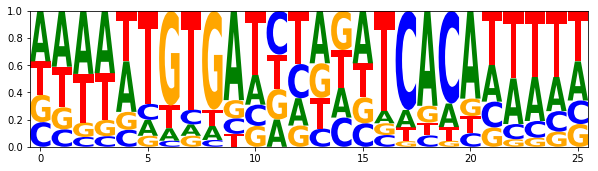

In [16]:
normalized_mat = lm.transform_matrix(counts_mat,normalize_values=True)
lm.Logo(normalized_mat)

# References

<a id='weblogo1990'></a>
Schneider,T.D. and Stephens,R.M. (1990) Nucleic Acids Res., 18, 6097-6100.